# Create Main Text Figures 4, 5
Maps showing differences between models and obs in SSTs, geopotential height, precipitation, for selected periods. 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd 
import xesmf as xe
import seaborn as sns
import warnings
import cmocean
import os
import re
import glob
import copy
import string
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import patches as mpatches
from matplotlib import lines as mlines
from matplotlib.legend_handler import HandlerTuple
from cartopy import crs as ccrs
import cmocean
from tqdm.notebook import tqdm


from funcs_support import get_params,get_filepaths,subset_to_srat,area_mean,utility_print
dir_list = get_params()
from funcs_load import load_raws

In [2]:
# Make reference grid to regrid to 
ref_grid = xr.Dataset({'lat':np.arange(-70.5,70.6,1.5),'lon':np.arange(-179.5,179.6,2)})
seas_list = ['MAM','OND','prevOND']

## Load SST trends

In [3]:
#--------------- Load SST trends ---------------
exp_id = {'obs':r'obs',
          'coupled':r'r[0-9]+i[0-9]+p[0-9]+f[0-9]+'}


dss = dict()
for exp in exp_id:
    # Get files to load
    df = get_filepaths(source_dir = 'proc')
    df = df.query('varname == "tostrends" and freq == "seasavg" and suffix == "spectrends"')
    # Subset by type (obs or cmip)
    df = df.loc[df.run.str.contains(exp_id[exp]),:]

    # Get models to proces
    mods = df.model.unique()
    dss[exp] = dict()
    for mod in tqdm(mods): 
        # Get files for this model
        # (both hist-none and hist-ssp245 (or any other exp) for that
        # matter are fine to load together, since no runs overlap between
        # them)
        df_tmp = df.query('model == "'+mod+'"')
    
        # Not using this for now, but here if you need it
        # (replacing runs with just integers, since what 
        # specific run it is is kinda irrelevant)
        runs = df_tmp.run.values
        
        # Open 
        ds_tmp = [xr.open_dataset(fn).sel(season=seas_list) for fn in df_tmp.path.values]
        
        # Regrid to standard grid 
        # (ignore_degenrate=True to avoid xesmf rc=506 error that occurs
        # occasionally at singular grid points like the poles)
        # Separated out because there's inconsistency in which model runs
        # are which grid, some are native, some are already pre-regridded,
        # so will have to regride every run separately
        rgrds = {}
        skip_runs = []
        for ds_idx in np.arange(0,len(ds_tmp)):
            if 'ncells' in ds_tmp[ds_idx]['tos_lslope'].sizes:
                print("Found 1-D grid, can't deal with that, skipping.")
                skip_runs.append(ds_idx)
                continue
            if 'lat' in ds_tmp[ds_idx].sizes:
                grid_id = 'rect'
            else:
                grid_id = 'nonrect'
    
            with warnings.catch_warnings():
                # Silence xesmf User warning about C_CONTINUOUS arrays
                warnings.filterwarnings('ignore')
    
                # Regrid, but minimize the number of times `xe.Regridder()` has 
                # to be called / regenerated, by only recreating the `rgrd` if 
                # that type of grid hasn't yet had one calculated for this model,
                # and then trying if one of the previously calculated `rgrds` works
                # (this is a consequence of me being cavalier about which grid 
                # version of files to download, leading to a bit of a mess with both
                # native and regrdidded grids flying around...) 
                try:
                    if grid_id not in rgrds:
                        rgrds[grid_id] = xe.Regridder(ds_tmp[ds_idx],ref_grid,'bilinear',
                                                      ignore_degenerate=True,periodic=True)
                    try:
                        ds_tmp[ds_idx] = rgrds[grid_id](ds_tmp[ds_idx].load())
                    except ValueError:
                        # Apparently sometimes the domain is slightly different in 
                        # lat between runs...? 
                        rgrd_tmp = xe.Regridder(ds_tmp[ds_idx],ref_grid,'bilinear',
                                                ignore_degenerate=True,periodic=True)
                        ds_tmp[ds_idx] = rgrd_tmp(ds_tmp[ds_idx].load())
                except:
                    print('Issue regridding model '+mod+', file '+str(ds_idx)+', skipping.')
                    skip_runs.append(ds_idx)
                    continue
                
        ds_tmp = [ds_tmp[idx] for idx in np.arange(0,len(ds_tmp)) if idx not in skip_runs]
    
        if len(ds_tmp)>0:
        
            # Put in run dimension for variables that need to be concatenated, 
            # to make `data_vars = 'minimal'` work below
            for ds_idx in np.arange(0,len(ds_tmp)):
                for var in ['tos_std','tos_lslope']:
                    ds_tmp[ds_idx][var] = ds_tmp[ds_idx][var].expand_dims({'run':[ds_idx]})
        
                ds_tmp[ds_idx] = ds_tmp[ds_idx][['tos_std','tos_lslope']]
            # Concat
            dss[exp][mod] = xr.concat(ds_tmp,dim='run',
                                 data_vars='minimal')
        else:
            warnings.warn('Model '+mod+' has no valid files.')
        
        del ds_tmp

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Found 1-D grid, can't deal with that, skipping.
Found 1-D grid, can't deal with that, skipping.
Found 1-D grid, can't deal with that, skipping.
Found 1-D grid, can't deal with that, skipping.
Found 1-D grid, can't deal with that, skipping.


/tmp/ipykernel_20014/3470056649.py:93: UserWarning: Model AWI-CM-1-1-MR has no valid files.
  warnings.warn('Model '+mod+' has no valid files.')


Issue regridding model MIROC6, file 0, skipping.
Found 1-D grid, can't deal with that, skipping.


/tmp/ipykernel_20014/3470056649.py:93: UserWarning: Model AWI-ESM-1-1-LR has no valid files.
  warnings.warn('Model '+mod+' has no valid files.')


In [4]:
#### Calculate SST indices 
reg_params = {'westernV':[{'lat':[-15,20],'lon':[120,160],'edgecolor':'tab:purple'},
                          {'lat':[20,35],'lon':[160,-150],'edgecolor':'tab:purple'},
                          {'lat':[-30,-15],'lon':[155,-150],'edgecolor':'tab:purple'}],
              'nino34':[{'lat':[-5,5],'lon':[170,-120],'edgecolor':'tab:orange'}]}

# Get boolean arrays for different SST regions
bools = dict()
for reg in reg_params:
    bools[reg] = []
    for chunk_idx in np.arange(0,len(reg_params[reg])):
        bool_tmp = ((ref_grid.lat >= reg_params[reg][chunk_idx]['lat'][0]) &
                    (ref_grid.lat <= reg_params[reg][chunk_idx]['lat'][1]))
        
        if reg_params[reg][chunk_idx]['lon'][0] > reg_params[reg][chunk_idx]['lon'][1]:
            bool_tmp = (bool_tmp & ((ref_grid.lon >= reg_params[reg][chunk_idx]['lon'][0]) |
                                    (ref_grid.lon <= reg_params[reg][chunk_idx]['lon'][1])))
        else:
            bool_tmp = (bool_tmp & ((ref_grid.lon >= reg_params[reg][chunk_idx]['lon'][0]) &
                                    (ref_grid.lon <= reg_params[reg][chunk_idx]['lon'][1])))
        
        bools[reg].append(bool_tmp)
    bools[reg] = xr.concat(bools[reg],dim='chunk').any('chunk')


# Get regional SST averages
dss_regs = {exp:{mod:xr.concat([area_mean(dss[exp][mod].where(bools[reg])) for reg in bools],
                          dim=pd.Index([reg for reg in bools],name='region'))
                 for mod in dss[exp]}
            for exp in dss}

# Calculate Western V Gradient
for exp in dss_regs:
    for mod in dss_regs[exp]:
        dss_regs[exp][mod] = xr.concat([dss_regs[exp][mod],
                               (dss_regs[exp][mod][['tos_lslope']].sel(region='nino34') - 
                                dss_regs[exp][mod][['tos_lslope']].sel(region='westernV')).expand_dims({'region':['wvg']})],
                              dim='region') 

In [5]:
# Models with both hist-ssp245 and hist-none runs have run-dependent
# start/end year variables that don't play nice with the bias calculation
# below
for mod in dss['coupled']:
    if 'run' in dss['coupled'][mod].start_year.sizes:
        for v in ['start_year','end_year']:
            dss['coupled'][mod][v] = dss['coupled'][mod][v].mean('run')

In [6]:
# Concat obs into single dataset
dss['obs'] = xr.concat([ds.expand_dims({'model':[mod]}) for mod,ds in dss['obs'].items()],
                       dim=pd.Index([mod for mod in dss['obs']],name='model'),
                       data_vars = 'minimal')

In [7]:
ds_bias = dict()
# Calculate difference between models and obs
for mod in dss['coupled']:
    ds_bias[mod] = dss['coupled'][mod] - dss['obs'].mean(('run','model'))


In [8]:
# Concatenate ds_bias into single ds for ease of processing
ds_bias = xr.concat([ds_bias[mod].expand_dims({'model':[mod]}).stack(idv = ['model','run'])
           for mod in ds_bias],
          dim='idv')


In [9]:
# Get which model runs have the same sign bias as the average 
# model run
pct_of_meantrend = (np.sign(ds_bias.tos_lslope) == np.sign(ds_bias.groupby('model').mean().mean('model')))

# Now get the number of model runs with the same sign bias as the 
# average model run bias as a percentage of the non-nan model-runs
# at that location / season / time period
pct_of_meantrend = (pct_of_meantrend.sum('idv') / 
                    (~np.isnan(ds_bias.tos_lslope)).sum('idv'))

## Load $\omega$ trends

In [10]:
#--------------- Load SST trends ---------------
exp_id = {'obs':r'reanalysis',
          'coupled':r'r[0-9]+i[0-9]+p[0-9]+f[0-9]+'}

dssw = dict()
for exp in exp_id:
    # Get files to load
    df = get_filepaths(source_dir = 'proc')
    df = df.query('varname == "wap500trends" and freq == "seasavg" and suffix == "spectrends"')
    # Subset by type (obs or cmip)
    df = df.loc[df.run.str.contains(exp_id[exp]),:]

    # Get models to proces
    mods = df.model.unique()
    dssw[exp] = dict()
    for mod in tqdm(mods): 
        # Get files for this model
        # (both hist-none and hist-ssp245 (or any other exp) for that
        # matter are fine to load together, since no runs overlap between
        # them)
        df_tmp = df.query('model == "'+mod+'"')
    
        # Not using this for now, but here if you need it
        # (replacing runs with just integers, since what 
        # specific run it is is kinda irrelevant)
        runs = df_tmp.run.values
        
        # Open 
        ds_tmp = [xr.open_dataset(fn).sel(season=seas_list) for fn in df_tmp.path.values]
        
        # Regrid to standard grid 
        # (ignore_degenrate=True to avoid xesmf rc=506 error that occurs
        # occasionally at singular grid points like the poles)
        # Separated out because there's inconsistency in which model runs
        # are which grid, some are native, some are already pre-regridded,
        # so will have to regride every run separately
        rgrds = {}
        skip_runs = []
        for ds_idx in np.arange(0,len(ds_tmp)):
            if 'ncells' in ds_tmp[ds_idx]['wap500_lslope'].sizes:
                print("Found 1-D grid, can't deal with that, skipping.")
                skip_runs.append(ds_idx)
                continue
            if 'lat' in ds_tmp[ds_idx].sizes:
                grid_id = 'rect'
            else:
                grid_id = 'nonrect'
    
            with warnings.catch_warnings():
                # Silence xesmf User warning about C_CONTINUOUS arrays
                warnings.filterwarnings('ignore')
    
                # Regrid, but minimize the number of times `xe.Regridder()` has 
                # to be called / regenerated, by only recreating the `rgrd` if 
                # that type of grid hasn't yet had one calculated for this model,
                # and then trying if one of the previously calculated `rgrds` works
                # (this is a consequence of me being cavalier about which grid 
                # version of files to download, leading to a bit of a mess with both
                # native and regrdidded grids flying around...) 
                try:
                    if grid_id not in rgrds:
                        rgrds[grid_id] = xe.Regridder(ds_tmp[ds_idx],ref_grid,'bilinear',
                                                      ignore_degenerate=True,periodic=True)
                    try:
                        ds_tmp[ds_idx] = rgrds[grid_id](ds_tmp[ds_idx].load())
                    except ValueError:
                        # Apparently sometimes the domain is slightly different in 
                        # lat between runs...? 
                        rgrd_tmp = xe.Regridder(ds_tmp[ds_idx],ref_grid,'bilinear',
                                                ignore_degenerate=True,periodic=True)
                        ds_tmp[ds_idx] = rgrd_tmp(ds_tmp[ds_idx].load())
                except:
                    print('Issue regridding model '+mod+', file '+str(ds_idx)+', skipping.')
                    skip_runs.append(ds_idx)
                    continue
                
        ds_tmp = [ds_tmp[idx] for idx in np.arange(0,len(ds_tmp)) if idx not in skip_runs]
    
        if len(ds_tmp)>0:
        
            # Put in run dimension for variables that need to be concatenated, 
            # to make `data_vars = 'minimal'` work below
            for ds_idx in np.arange(0,len(ds_tmp)):
                for var in ['wap500_std','wap500_lslope']:
                    ds_tmp[ds_idx][var] = ds_tmp[ds_idx][var].expand_dims({'run':[ds_idx]})
        
                ds_tmp[ds_idx] = ds_tmp[ds_idx][['wap500_std','wap500_lslope']]
            # Concat
            dssw[exp][mod] = xr.concat(ds_tmp,dim='run',
                                 data_vars='minimal')
        else:
            warnings.warn('Model '+mod+' has no valid files.')
        
        del ds_tmp

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [11]:
for mod in dssw['coupled']:
    for v in ['start_year','end_year']:
        if 'run' in dssw['coupled'][mod][v].sizes:
            dssw['coupled'][mod][v] = dssw['coupled'][mod][v].isel(run=0,drop=True)

In [12]:
# Concatenate into single ds
dssw['obs'] = xr.concat([dssw['obs'][mod].expand_dims({'model':[mod]})
           for mod in dssw['obs']],
          dim='model').mean(('model','run'))

# Calculate model-obs difference
dssw['coupled'] = {mod:(ds - dssw['obs']) for mod,ds in dssw['coupled'].items()}

dssw['coupled'] = xr.concat([(dssw['coupled'][mod].expand_dims({'model':[mod]}).
                              stack(idv = ['model','run']).
                              drop_vars(['start_year','end_year','plev'],errors='ignore'))
                             for mod in dssw['coupled']],
                              dim='idv')

In [13]:
# Merge into existing ds_bias
ds_bias = xr.merge([dssw['coupled'],ds_bias])

## Load $P$ trends

In [14]:
# Load model and obs data
dssp = {exp:load_raws({'varname':'prtrends','suffix':'HoAfrica','exp':exp},
                  source_dir = 'proc',force_load = True)
       for exp in ['amip','hist-ssp245','hindcastsf','obs']}

In [15]:
for v in ['start_year','end_year']:
    ds_bias[v] = ds_bias[v].mean('idv')

In [16]:
# Subset to just the specific trends desired
for exp in dssp:
    for mod in dssp[exp]:
        tps_tmp = [((sy in dssp[exp][mod].start_year) and
                (ey in dssp[exp][mod].end_year)) for sy,ey in zip(ds_bias['start_year'].values,ds_bias['end_year'].values)]
        tps_tmp = ds_bias['time_period'][tps_tmp]
        
        dssp[exp][mod] = xr.concat([dssp[exp][mod].sel(start_year=tps_tmp['start_year'][yidx],
                                     end_year=tps_tmp['end_year'][yidx])
                               for yidx in range(tps_tmp.sizes['time_period'])],
                              dim=tps_tmp['time_period'])

In [17]:
# Put into idv stacked format
start_year = dssp['obs']['CHIRPS'].start_year
end_year = dssp['obs']['CHIRPS'].end_year
dssp = {exp:xr.concat([(dssp[exp][mod].expand_dims({'model':[mod]}).
                              stack(idv = ['model','run']).
                              drop_vars(['start_year','end_year',
                                         *[v for v in dssp[exp][mod]
                                          if v not in 
                                           ['prtrend','pr_tsslope','trend_length','pr_std','pr_iqr']]],
                                        errors='ignore'))
                             for mod in dssp[exp]],
                              dim='idv')
         for exp in dssp}

In [18]:
# Broadcast amip out to put in NaNs for timeperiods outside of its range
dssp['amip'] = xr.concat([dssp['amip'],
                       dssp['obs'][['time_period']].sel(time_period=['long1','wet1'])],
                      dim='time_period')

In [19]:
# Unbroadcast trend_length and add start / end year back in
for exp in dssp:
    dssp[exp]['trend_length'] = dssp[exp]['trend_length'].mean('idv')
    dssp[exp]['start_year'] = (('time_period'),start_year.values)
    dssp[exp]['end_year'] = (('time_period'),end_year.values)

In [20]:
# Set up hindcast 
dssp['nmme_short'] = dssp['hindcastsf'].sel(lead=0.5)
dssp['nmme_mid'] = dssp['hindcastsf'].sel(lead=slice(1.5,3.6)).mean('lead')
dssp['nmme_long'] = dssp['hindcastsf'].sel(lead=slice(4.5,6.6)).mean('lead')

In [21]:
# Load double-peaked area info 
srat = xr.open_dataset(dir_list['aux']+'pr_doyavg_CHIRPS_historical_seasstats_dunning_19810101-20141231_HoAfrica.nc').seas_ratio


## Plot

In [22]:
def plot_multibias(save_fig = False,
                   output_fn = None,
                    #----------------- Input data -----------------
                    #------ Datasets
                    ds_box = dssp,
                    box_var = 'prtrend',
                    box_reg = 'HoA-bimod',
                    box_factor = 10, # multiplies plot data
                    box_varlabel = r'$P$ trend [mm/day/10yr]',
                    
                    ds_field = ds_bias,
                    field_var = 'tos_lslope',
                    field_varlabel = 'CMIP6 SST trend bias',
                    field_varlabel_add = '\nCoupled mods. - Obs [K/year]',
                    
                    ds_contour = ds_bias, # or None
                    contour_var = 'wap500_lslope',
                    contour_varlabel = r'500 hPa $\omega$ trend bias',
                    
                    plot_hatch = pct_of_meantrend, # or None

                    srat = srat,
                    
                    #------ Selections
                    # Which obs mods to highlight 
                    obs_mods = ['CHIRPS','GPCP','GPCC-full'],
                    cbar_params = {'vmin':-0.1,'vmax':0.1,'cmap':cmocean.cm.balance,'levels':21},
                    colors = {'obs':'tab:red','hist-ssp245':'tab:green','amip':'tab:blue',
                              'nmme_short':'lightblue','nmme_mid':'lightgreen','nmme_long':'lightgreen'},
                    labels = {'obs':'Obs.','hist-ssp245':'CMIP6','amip':'AMIP6',
                              'nmme_short':'Short lead','nmme_mid':'Long lead','nmme_long':'Long lead'},
                    box_exps = ['amip','nmme_short','hist-ssp245','nmme_mid'],
                    
                    hatch_thresh = 0.8,
                    
                    seas_box = 'MAM',
                    seas_field = 'MAM',
                    time_periods = ['rowell','dry0','long0','wet1'], # should do wet1
                    
                    period_names = {'rowell':'Rowell et al. (2015)',
                                    'long0':'Full length',
                                    'dry0':'Max drying trend',
                                    'wet1':'Max wetting trend'},
                    
                    #----------------- Plot characteristics -----------------
                    figsize=(17,8),
                    ncol=2,
                    dashed_pattern = [1,2],
                    contour_levels=[-0.003,-0.0015,0.0015,0.003],
                    contour_linestyles=['--','--','-','-'],

                    reg_params = {'westernV':[{'lat':[-15,20],'lon':[120,160],'edgecolor':'tab:purple'},
                                              {'lat':[20,35],'lon':[160,-150],'edgecolor':'tab:purple'},
                                              {'lat':[-30,-15],'lon':[155,-150],'edgecolor':'tab:purple'}],
                                  'nino34':[{'lat':[-5,5],'lon':[170,-120],'edgecolor':'tab:olive'}]}, # or None,
                    reg_param_names = {'westernV':'Western V','nino34':'Niño 3.4'},
                  ):

    #----------------- further Input setup -----------------
    # Change matplotlib line params to make dashed lines more distinguished from
    # solid ones... (in contour)
    #plt.rcParams['lines.dashed_pattern']= dashed_pattern

    nrow = np.ceil(len(time_periods) / ncol)

    # Add years to period names
    period_names = {tp:((str(int(ds_field.sel(time_period=tp).start_year.values))+'-'+
                                        str(int(ds_field.sel(time_period=tp).end_year.values)))+'\n'+
                                       txt)
                                   for tp,txt in period_names.items()}
    
    #----------------- Plot -----------------    
    fig = plt.figure(figsize=figsize)
    plot_ratio = 6 # Ratio of column to boxplot column
    gs = fig.add_gridspec(int(nrow), int(ncol*plot_ratio))
    
    
    for tp,tp_idx in zip(time_periods,np.arange(0,len(time_periods))):
        #------------- Precip boxes -------------
        ax = fig.add_subplot(gs[tp_idx // ncol, (tp_idx % ncol)*plot_ratio])
    
        # Get data
        dfp = pd.concat([ds_box[exp].sel(season=seas_box,time_period=tp,region=box_reg)[box_var].expand_dims({'exp':[exp]}).to_dataframe()
                     for exp in ds_box])
    
        obs_df = copy.deepcopy(dfp.loc['obs'])
        obs_df['typ'] = 'supp'
        obs_df.loc[[mod in obs_mods for mod in obs_df.reset_index().model],'typ'] = 'main'

        # Change from mm/day/year to mm/day/10yr
        obs_df[box_var] = obs_df[box_var]*box_factor
        
        # Plot obs data as swarm
        sns.swarmplot(data=obs_df.reset_index(),
                     y=box_var,hue='typ',
                     palette=['lightgrey','tab:red'],
                     hue_order = ['supp','main'],
                      size=4,
                     ax = ax)
        # Remove seaborn-generated legend
        plt.legend([],[], frameon=False)
        
        
        # Plot model data as boxplots
        for exp,loc in zip(box_exps,[0.85,1.15,1.85,2.15]):
            plot_data = dfp.loc[exp][box_var].values*box_factor
            bplot = ax.boxplot(plot_data[~np.isnan(plot_data)],
                               patch_artist=True,positions=[loc],widths=0.3,
                               whis=[5,95],flierprops = {'marker':'.','markersize':2})
                               
        
            # Set colors of boxplots
            for item in ['boxes', 'whiskers', 'fliers', 'caps']:
                plt.setp(bplot[item],color=colors[exp])
            plt.setp(bplot['medians'],color='white')
            plt.setp(bplot['fliers'],markeredgecolor=colors[exp])
        
        ax.axhline(0,color='k',linestyle='--')
        if (tp_idx % ncol) == 0:
            ax.set_ylabel(box_varlabel,fontsize=13,fontweight='bold')
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')
    
        ax.set_xlim(-0.75,2.5)
        ax.set_ylim(-0.14*box_factor,0.14*box_factor)
    
        ax.tick_params(axis='x',which='both',labelbottom=False,bottom=False)
        ax.set_yticks(np.arange(-0.1,0.11,0.05)*box_factor)
        ax.spines[['right','left','top','bottom']].set_visible(False)
    
        # Add legend in first plot
        if tp_idx == 0:
            # Set label for obs models listed to start a new line every 
            # two obs product names
            obs_label = copy.deepcopy(obs_mods)
            if len(obs_label)>2:
                obs_label[2:None:2] = ['\n'+k for k in obs_label[1:None:2]]
            # Legend
            leg_patches = [mlines.Line2D([0],[0],marker='o',mfc='tab:red',mec='tab:red',color='none',label=', '.join(obs_label)),
                           mlines.Line2D([0],[0],marker='o',mfc='lightgrey',mec='lightgrey',color='none',label='Other obs.'),
                           *[mpatches.Patch(color=colors[v],label=labels[v])
                          for v in box_exps]]
            ax.legend(handles=leg_patches,fontsize=9,
                      loc = 'upper right',bbox_to_anchor = (-0.7,0.9),ncol=1)
                      #loc='lower left',bbox_to_anchor=(-0.7,1.01),ncol=3)
    
        # Subplot lettering
        ax.annotate(string.ascii_lowercase[tp_idx]+'.',
                            [0.01,0.90],xycoords='axes fraction',
                            va='bottom',ha='left',fontsize=15,fontweight='bold')

        ## Add reference legend boxplot below main legend
        if tp_idx == 0:
            ax = fig.add_axes([0, 0.65, 0.2, 0.1])
            widths = 0.05
            bplot = ax.boxplot(np.arange(-50,51),
                                           patch_artist=True,widths=widths,
                                           whis=[5,95],flierprops = {'marker':'.','markersize':2})
            
            # Set colors of boxplots
            for item in ['boxes', 'whiskers', 'fliers', 'caps']:
                plt.setp(bplot[item],color='grey')
            plt.setp(bplot['medians'],color='white')
            plt.setp(bplot['fliers'],markeredgecolor='grey')
            
            
            for text,loc in zip([r'5%',r'25%','Median',r'75%',r'95%'],
                                [-45,-25,0,25,45]):
                
                ax.annotate(text,xy=(1+widths/2+0.025,loc),ha='left',va='center',
                            fontsize=12)
            
            ax.axis('off')
        
        #------------- Trend maps -------------
        ax = fig.add_subplot(gs[tp_idx // ncol, ((tp_idx % ncol)*plot_ratio+1):((tp_idx % ncol)*plot_ratio+plot_ratio-1)],
                             projection=ccrs.EckertIV(central_longitude=110))
    
        # Get plot data
        plot_data = ds_field.sel(time_period=tp,season=seas_field)[field_var]
        
        plot_data = plot_data.mean('idv')
        
        # Plot filled in
        (plot_data.plot(**cbar_params,transform=ccrs.PlateCarree(),add_colorbar=False))
    
        if plot_hatch is not None:
            # Add hatching for < 2/3 model agreement
            (plot_hatch.sel(time_period=tp,season=seas_field).
             plot.contourf(colors='None',levels=[0,hatch_thresh],hatches = ['..',None],add_colorbar=False,
                                                transform=ccrs.PlateCarree()))
        
        # Plot zero line
        plot_data.plot.contour(levels=[0],colors=['grey'],transform=ccrs.PlateCarree())
    
        # Get wap500 data
        plot_dataw = ds_contour.sel(time_period=tp,season=seas_field)[contour_var].mean('idv')
        # Spatially smooth
        plot_dataw = plot_dataw.coarsen({'lat':5,'lon':5},boundary = 'trim').mean()
        # Plot wap500 as contours
        cs = plot_dataw.plot.contour(colors='g',levels=contour_levels,
                    linestyles=contour_linestyles,transform=ccrs.PlateCarree(),
                           linewidths=1.5)

        # Add shading for study area
        srat.plot.contourf(levels=[0,1],colors=['darkorchid','none'],
                                      transform=ccrs.PlateCarree(),
                           add_colorbar=False)
    
        
        # Plot equator
        ax.axhline(0,color='k',linestyle='--')
        
        ax.coastlines()
    
        # Add title
        ax.set_title(period_names[tp],fontsize=15,fontweight='bold')
    
        # Add legend in first plot
        if tp_idx == 0:
            # Legend patches, labels
            leg_patches = list()
            leg_labels = list()
            if contour_var is not None:
                leg_patches.append(mlines.Line2D([0],[0],color='g'))
                leg_labels.append(contour_varlabel)
            leg_patches.append(mpatches.Patch(edgecolor='k',facecolor=cmocean.cm.balance(0.7)))
            leg_labels.append(field_varlabel)
            if plot_hatch is not None:
                leg_patches.append(mpatches.Patch(edgecolor='k',facecolor='None',hatch='..'))
                leg_labels.append( '< '+str(hatch_thresh)+' of model-runs\nhave same sign bias')
    
            # plot legend
            leg = ax.legend(handles=leg_patches,fontsize=9,
                            labels = leg_labels,
                            handler_map = {list: HandlerTuple(None)},
                            loc = 'upper left',bbox_to_anchor=(1.05,1.05),ncol=1)
                      #loc='lower right',bbox_to_anchor=(1.3,1.35),ncol=3)
            # From here: https://stackoverflow.com/questions/53849888/make-patches-bigger-used-as-legend-inside-matplotlib
            # to make the dots visible in legend patch
            for patch in leg.get_patches():
                patch.set_height(15)
                patch.set_y(-3)

        # Plot additional regions if desired
        if tp_idx == 0:
            for reg in reg_params:
                for chunk_idx in range(len(reg_params[reg])):
                    if reg_params[reg][chunk_idx]['lon'][1] > reg_params[reg][chunk_idx]['lon'][0]:
                        width = np.abs(np.diff(reg_params[reg][chunk_idx]['lon']))[0]
                    else:
                        width = (180 - reg_params[reg][chunk_idx]['lon'][0]) + np.abs(-180- reg_params[reg][chunk_idx]['lon'][1])
        
                    ax.add_patch(mpatches.Rectangle([reg_params[reg][chunk_idx]['lon'][0],reg_params[reg][chunk_idx]['lat'][0]],
                                      width=width,height=np.diff(reg_params[reg][chunk_idx]['lat'])[0],
                                    edgecolor=reg_params[reg][chunk_idx]['edgecolor'],facecolor='none',
                                                    linewidth=3,
                                                    transform=ccrs.PlateCarree()))
                ## Add labels to regions (attached to the last chunk)
                # Get arrow point (in data units)
                arrow_point = [reg_params[reg][chunk_idx]['lon'][1],
                                np.mean(reg_params[reg][chunk_idx]['lat'])]
                # Nudge it away from the edge
                if arrow_point[0] > 0:
                    arrow_point[0] = arrow_point[0] - 5
                else:
                    arrow_point[0] = arrow_point[0] + 5
               
                                
                ax.annotate(reg_param_names[reg],
                            xy = arrow_point,
                            xytext = (10,0),
                            xycoords = 'data',
                            textcoords = 'offset fontsize',
                            fontsize=14,
                             arrowprops = {'arrowstyle':'->',
                                           'linewidth':2,
                                           'color':reg_params[reg][chunk_idx]['edgecolor']},
                             transform=ccrs.PlateCarree())
                            
                    

    
    #------ Plot annotations
    #fig.subplots_adjust(right=0.825)
    #cax = fig.add_axes([0.875, 0.15, 0.015, 0.7])
    cax = fig.add_axes([0.85, 0.275, 0.03, 0.45])
    levels = mpl.ticker.MaxNLocator(nbins=cbar_params['levels']).tick_values(cbar_params['vmin'],cbar_params['vmax'])
    norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params['cmap'].N, extend='both')
    sm = plt.cm.ScalarMappable(cmap=cbar_params['cmap'],norm=norm)
    cbar = plt.colorbar(sm,cax=cax)
    cbar.set_label('Mean '+field_varlabel+field_varlabel_add,fontsize=13,fontweight='bold')
    cbar.ax.tick_params(labelsize=12)
    
    #------ Plot adjustments
    fig.subplots_adjust(wspace=0.05, hspace=-0.1)
    
    #------ Export
    if save_fig:
        fig.subplots_adjust(left = 0.25)
        utility_print(output_fn)


## Main text Figure 4

/dx02/kschwarz/project_data/future_stability/figures/figure4.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figure4.png saved!


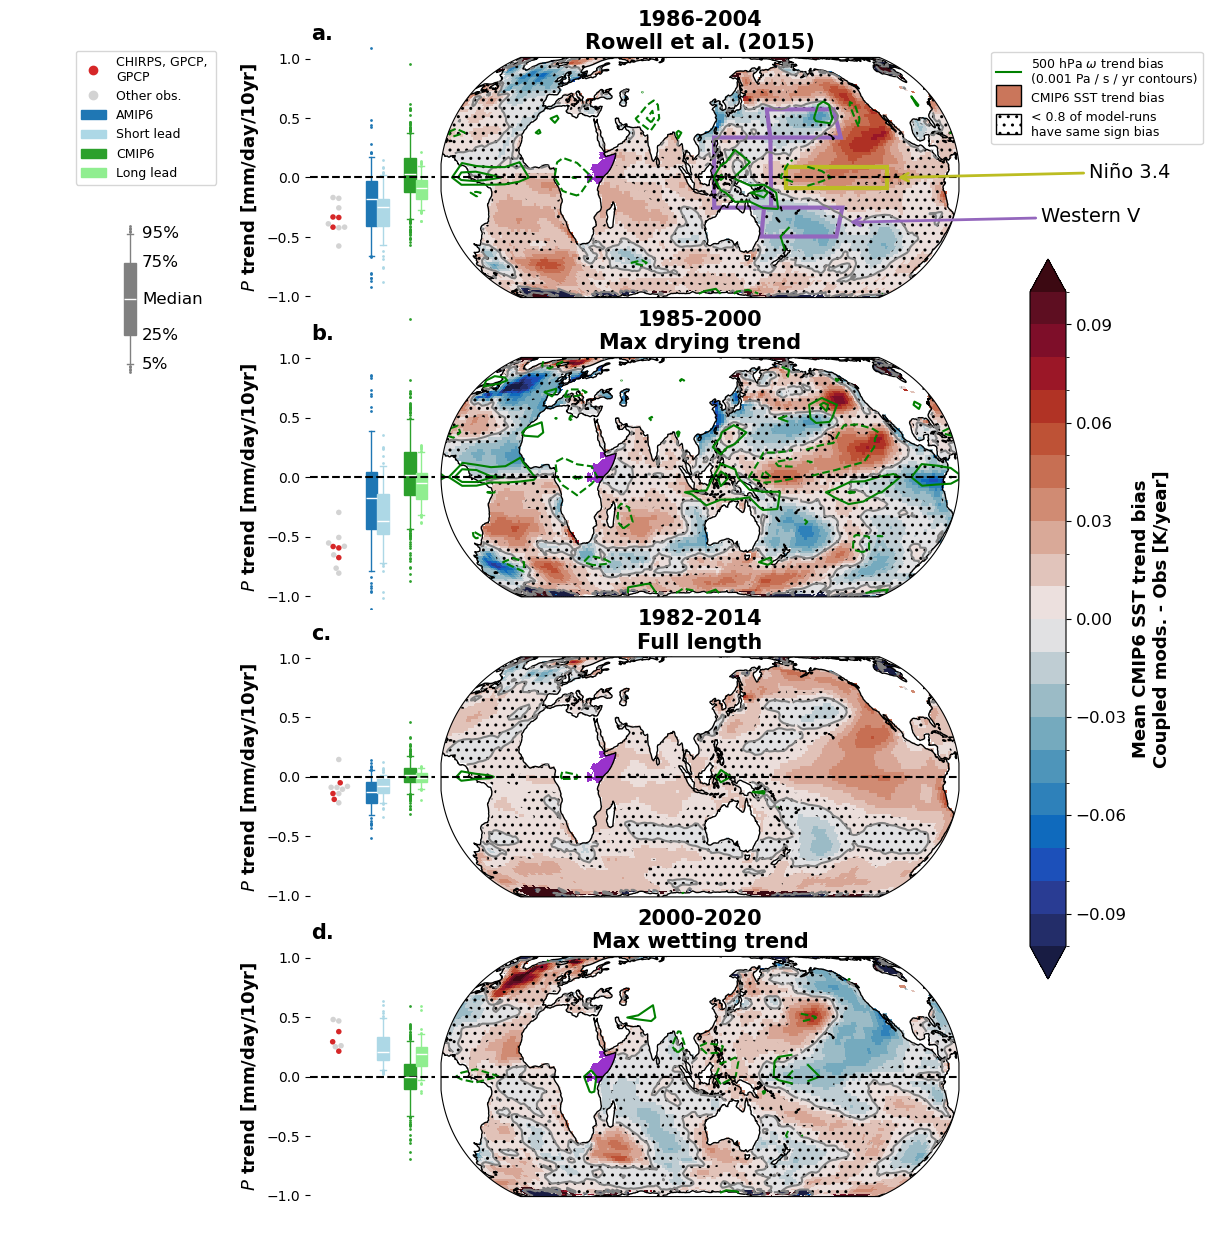

In [23]:
plot_multibias(ds_box = dssp,
               box_var = 'prtrend',
                    
               ds_field = ds_bias,
               field_var = 'tos_lslope',
               field_varlabel = 'CMIP6 SST trend bias',
                    
               ds_contour = ds_bias, # or None
               contour_var = 'wap500_lslope',
               contour_varlabel = (r'500 hPa $\omega$ trend bias'+
                                        '\n(0.001 Pa / s / yr contours)'),
               contour_levels = [-0.002,-0.001,0.001,0.002],

               ncol = 1,
               figsize = (12,16),
                    
               plot_hatch = pct_of_meantrend['tos_lslope'], # or None
               save_fig = True,
               output_fn = dir_list['figs']+'figure4')

### Alternate version with theil-sen slopes for rainfall

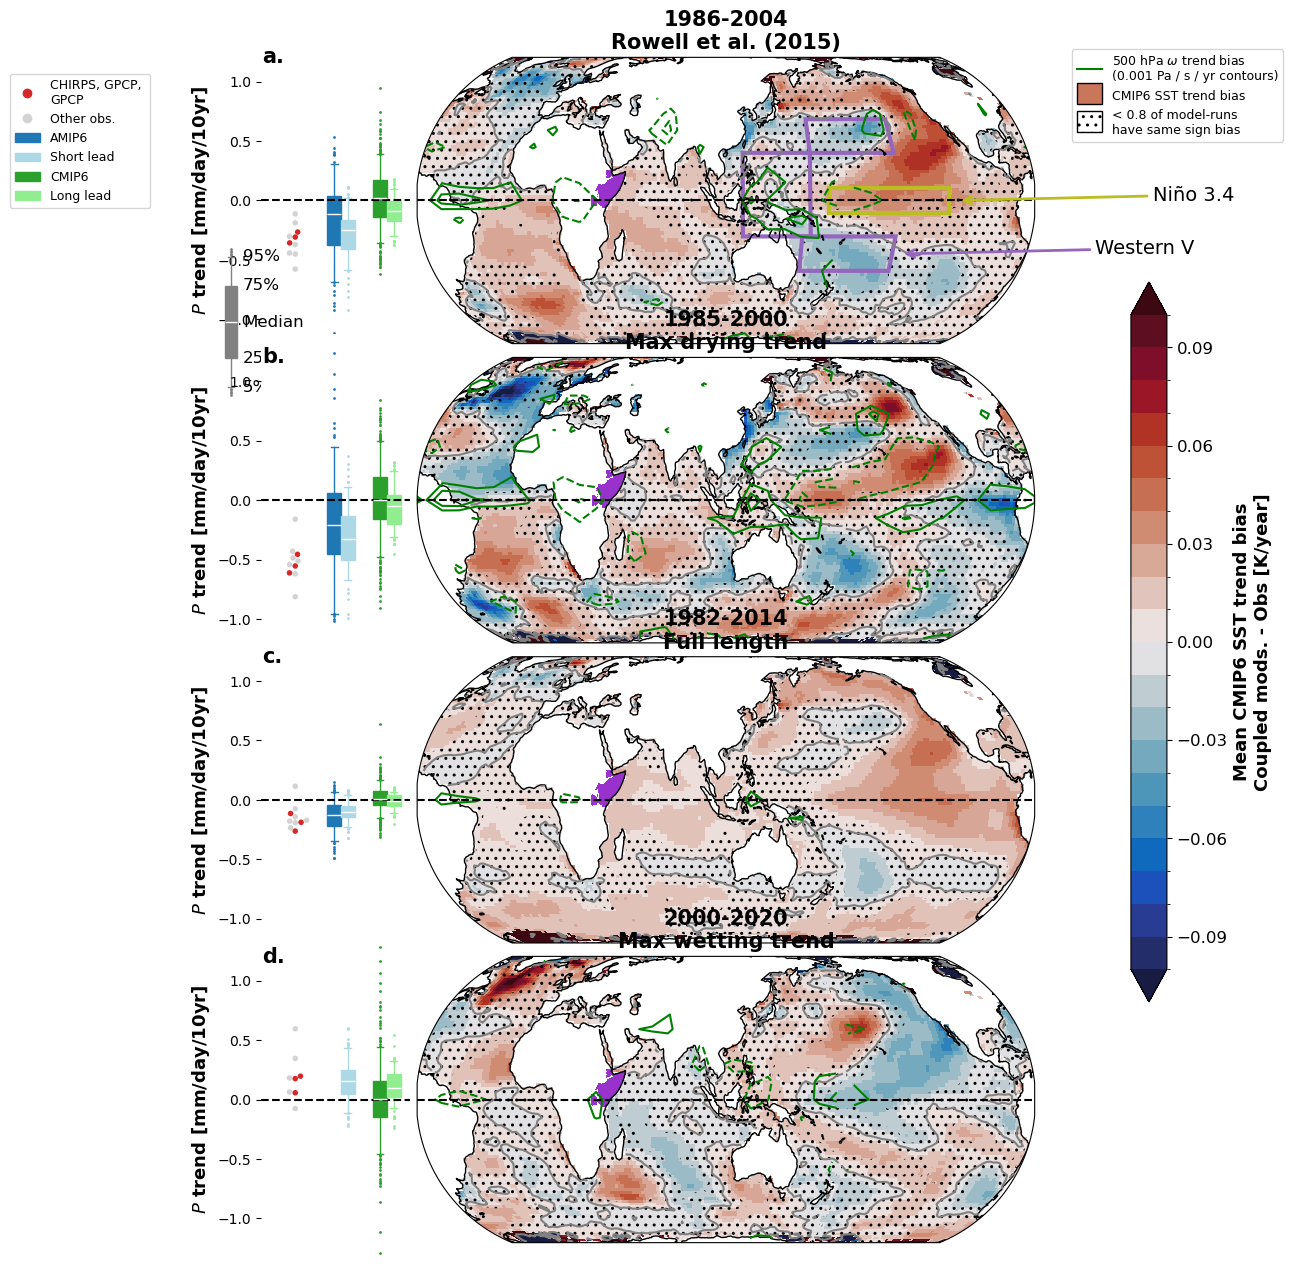

In [24]:
plot_multibias(ds_box = dssp,
               box_var = 'pr_tsslope',
                    
               ds_field = ds_bias,
               field_var = 'tos_lslope',
               field_varlabel = 'CMIP6 SST trend bias',
                    
               ds_contour = ds_bias, # or None
               contour_var = 'wap500_lslope',
               contour_varlabel = (r'500 hPa $\omega$ trend bias'+
                                        '\n(0.001 Pa / s / yr contours)'),
               contour_levels = [-0.002,-0.001,0.001,0.002],

               ncol = 1,
               figsize = (12,16),
                    
               plot_hatch = pct_of_meantrend['tos_lslope'], # or None
               save_fig = False,
               output_fn = dir_list['figs']+'EXTRAfigure4_tsslope')

## Supp Docs Figure S18
Showing raw trends instead of biases

/dx02/kschwarz/project_data/future_stability/figures/figureS18.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS18.png saved!


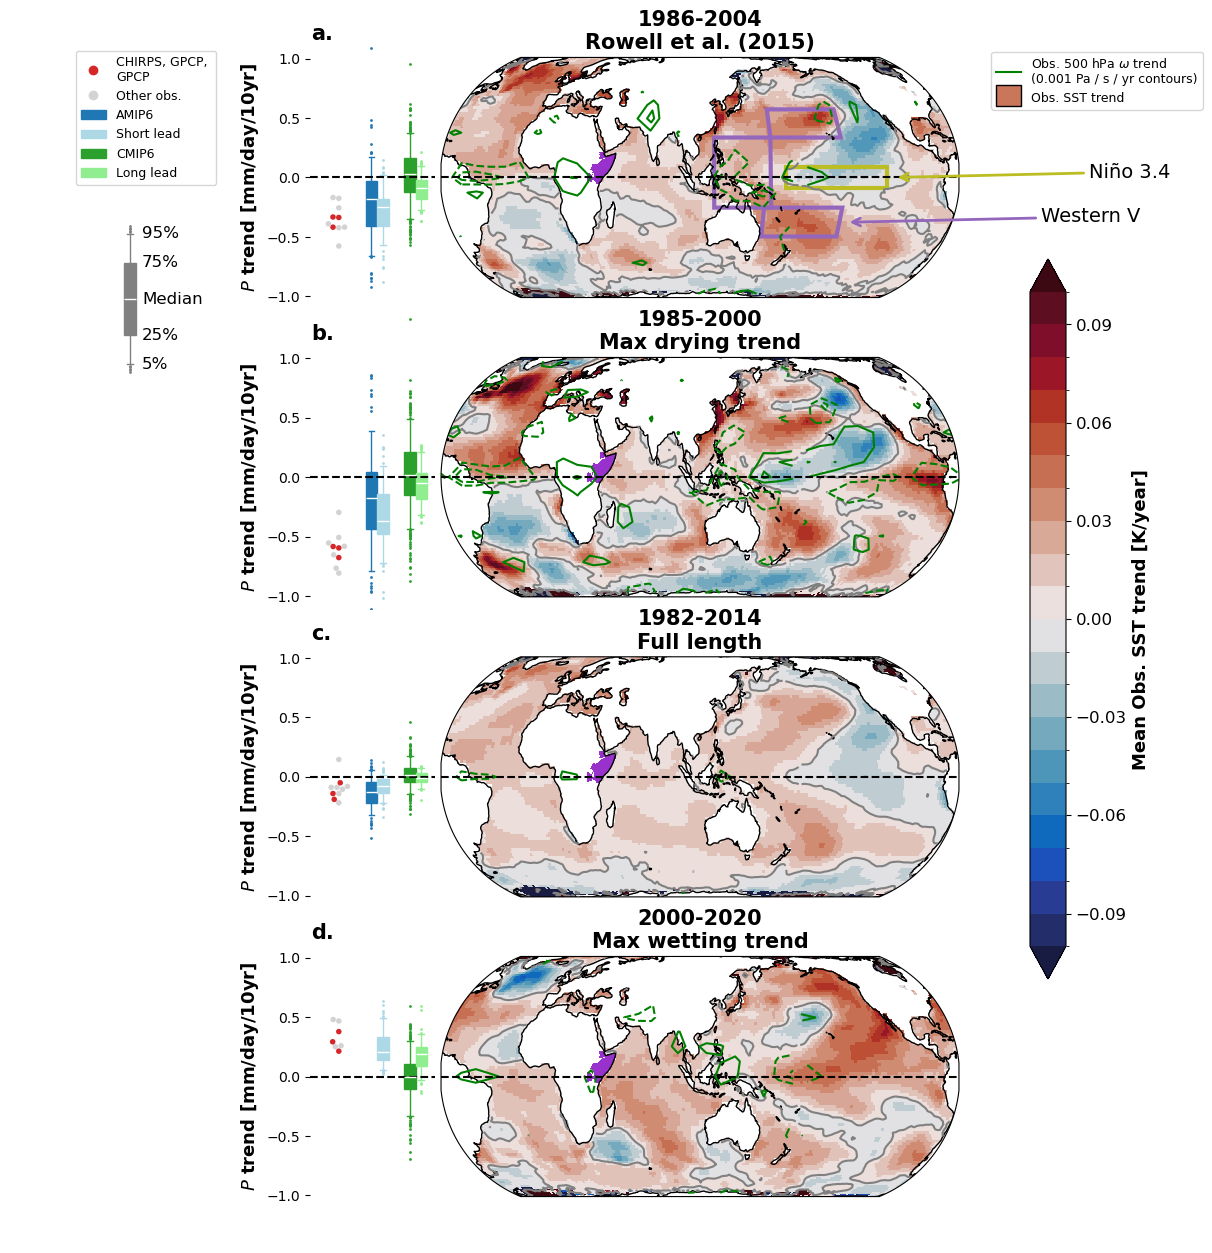

In [25]:
plot_multibias(ds_box = dssp,
               box_var = 'prtrend',
                    
               ds_field = dss['obs'].stack(idv = ('model','run')),
               field_var = 'tos_lslope',
               field_varlabel = 'Obs. SST trend',
               field_varlabel_add = ' [K/year]',
                    
               ds_contour = dssw['obs'].expand_dims({'idv':[0]}), # or None
               contour_var = 'wap500_lslope',
               contour_varlabel =  (r'Obs. 500 hPa $\omega$ trend'+
                                        '\n(0.001 Pa / s / yr contours)'),
               contour_levels = [-0.002,-0.001,0.001,0.002],

               ncol = 1,
               figsize = (12,16),
                    
               plot_hatch = None, # or None
               save_fig = True,
               output_fn = dir_list['figs']+'figureS18')

## Main text Figure 5

In [26]:
dss_regs = {exp:xr.concat([ds.expand_dims({'model':[mod]}).stack(idv = ['model','run']) for mod,ds in dss_regs[exp].items()],
                            dim='idv')
 for exp in dss_regs}
for exp in dss_regs:
    for v in ['start_year','end_year']:
        if 'idv' in dss_regs[exp][v].sizes:
            dss_regs[exp][v] = dss_regs[exp][v].mean('idv')

In [27]:
time_periods = ['rowell','dry0','long0','wet1']
                    
period_names = {'rowell':'Rowell et al. (2015)',
                'long0':'Full length',
                'dry0':'Max drying trend',
                'wet1':'Max wetting trend'}

# Add years to period names
period_names = {tp:((str(int(dss_regs['obs'].time_period.sel(time_period=tp).start_year.values))+'-'+
                                        str(int(dss_regs['obs'].time_period.sel(time_period=tp).end_year.values)))+'\n'+
                                       txt)
                                   for tp,txt in period_names.items()}


reg_names = {'westernV':'Western V',
             'nino34':'Niño 3.4',
             'wvg':'WVG'}



/dx02/kschwarz/project_data/future_stability/figures/figure5.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figure5.png saved!


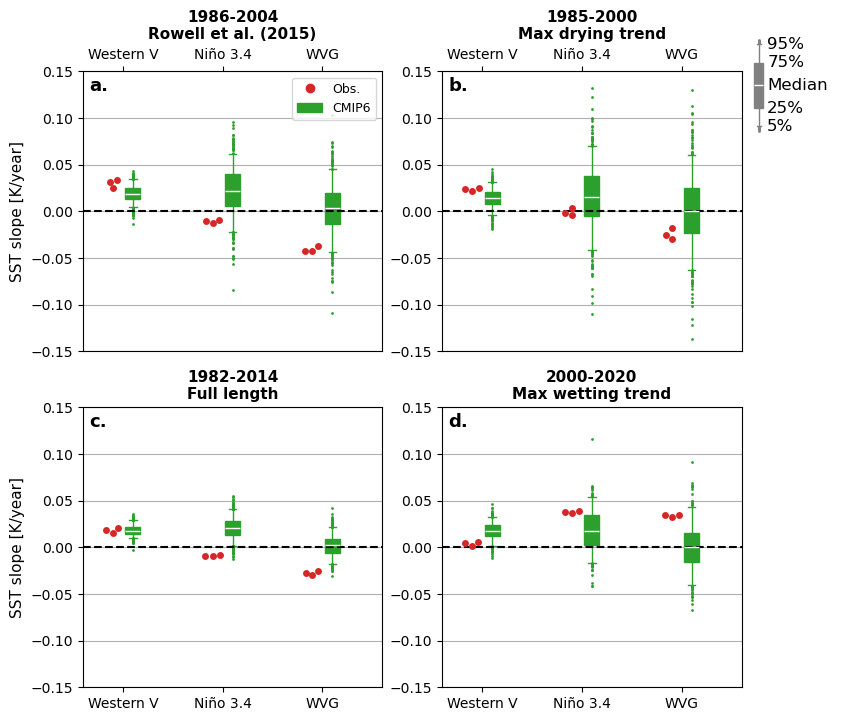

In [28]:
save_fig = True
output_fn = dir_list['figs']+'figure5'

fig = plt.figure(figsize=(8.5,8))

seas = 'MAM'
ncol = 2 

for tp,tp_idx in zip(time_periods,range(len(time_periods))):
    ax = plt.subplot((len(time_periods)+ 1)//ncol,ncol,tp_idx+1)

    # Swarmplot for obs, x axis is region
    plot_data = dss_regs['obs'].sel(season=seas,time_period=tp)['tos_lslope']

    sns.swarmplot(data=plot_data.to_dataframe().drop(['model','run'],axis=1).reset_index(),
                  x='region',y='tos_lslope',color='tab:red',ax=ax)


    # Boxplots for mods, x axis is region
    for reg,loc in zip(dss_regs['coupled'].region.values,[0.2,1.2,2.2]):
        plot_data = dss_regs['coupled'].sel(season=seas,region=reg,time_period=tp)['tos_lslope']
        plot_data = plot_data.values.flatten()

        bplot = ax.boxplot(plot_data[~np.isnan(plot_data)],
                            patch_artist=True,positions=[loc],
                            widths=0.15,whis=[5,95],flierprops = {'marker':'.','markersize':2})

        # Set colors of boxplots
        for item in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bplot[item],color='tab:green')
        plt.setp(bplot['medians'],color='white')
        plt.setp(bplot['fliers'],markeredgecolor='tab:green')

    # Plot annotations
    ax.axhline(0,color='k',linestyle='--')

    # Y Axis
    ax.set_ylim([-0.15,0.15])
    if (tp_idx % ncol) == 0:
        ax.set_ylabel('SST slope [K/year]',fontsize=11)
    else:
        ax.set_ylabel('')

    # X Axis
    ax.set_xlabel('')
    
    ax.set_xticks([0.1,1.1,2.1])
    ax.set_xticklabels([reg_names[reg] for reg in dss_regs['obs'].region.values])
    if tp_idx < 2:
        ax.tick_params(axis='x',bottom=False,labelbottom=False,top=True,labeltop=True)

    ax.grid(axis='y')

    ax.set_title(period_names[tp],fontsize=11,fontweight='bold')

    # Add legend in first plot
    if tp_idx == 0:
        # Legend
        leg_patches = [mlines.Line2D([0],[0],marker='o',mfc='tab:red',mec='tab:red',color='none',label='Obs.'),
                       mpatches.Patch(color='tab:green',label='CMIP6')]
        ax.legend(handles=leg_patches,fontsize=9,
                    loc='upper right')
    
    # Subplot lettering
    ax.annotate(string.ascii_lowercase[tp_idx]+'.',
                        [0.02,0.98],xycoords='axes fraction',
                        va='top',ha='left',fontsize=13,fontweight='bold')

    ## Add reference legend boxplot
    if tp_idx == 1:
        ax = fig.add_axes([0.82,0.8, 0.2, 0.125])
        widths = 0.05
        bplot = ax.boxplot(np.arange(-50,51),
                                       patch_artist=True,widths=widths,
                                       whis=[5,95],flierprops = {'marker':'.','markersize':2})
        
        # Set colors of boxplots
        for item in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bplot[item],color='grey')
        plt.setp(bplot['medians'],color='white')
        plt.setp(bplot['fliers'],markeredgecolor='grey')
        
        
        for text,loc in zip([r'5%',r'25%','Median',r'75%',r'95%'],
                            [-45,-25,0,25,45]):
            
            ax.annotate(text,xy=(1+widths/2+0.025,loc),ha='left',va='center',
                        fontsize=12)

        
        ax.axis('off')

if save_fig:
    utility_print(output_fn)